# Tutorial 7

**Procedure notes:**

* You should be running this notebook in EC2 on AWS.
* Your EC2 instance *should be in the same AWS region as the target S3 bucket*, which is .
  * Reminder, you can check the target S3 bucket's region in more than one way, one way: https://docs.aws.amazon.com/cli/latest/reference/s3api/get-bucket-location.html
* We'll identify the AWS Region of the target S3 bucket. (I know the URL already because of dev privilege.)
* But we'll still follow the end to end process that operates on the assumption that you've launched your EC2 at the appropriate.

In [1]:
from IPython.display import HTML
from json import dumps
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy

In [2]:
from netrc import netrc
from platform import system
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")

Username: jmcnelis
Password: ········


## Cloud data from GRACE-FO

Data from the [**TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2**](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2) dataset can be obtained from/in the cloud.

To search Earthdata from this notebook for the specific collections desired, we can use the following code with key words that describe our dataset. First we will search for the GRACE-FO dataset. This snippet of Python code uses the `requests` module to get collection metadata from the CMR:

```python
grace_coll = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/collections.umm_json", 
    params={'ShortName': "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2",
            'provider': "POCLOUD",
            'token': _token},
).json()
```

However, we don't need the collection metadata to carry out our simple procedure in this notebook. So, retrieve the granule (file) metadata from the CMR instead:

In [3]:
grace_gran = requests.get(
    url="https://cmr.earthdata.nasa.gov/search/granules.umm_json", 
    params={'ShortName': "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2", 
            'provider': "POCLOUD",
            'token': _token, },
).json()

grace_gran['items'][0]['meta']

{'concept-type': 'granule',
 'concept-id': 'G1965295346-POCLOUD',
 'revision-id': 1,
 'native-id': 'GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-11-10T18:37:10.446Z'}

In [4]:
grace_gran['items'][0]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

You want this one! ```'Type': 'GET DATA'```

Download the file and open it with xarray in memory.

In [5]:
grace_url = grace_gran['items'][0]['umm']['RelatedUrls'][1]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc'

**since we're in S3, we can use neat builtins...**

but for now, testing locally, we should just download and proceed using normal HTTPS protocol.

In [6]:
r = requests.get(grace_url)
with open('tutorial7_data_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h tutorial7_data_GRACEFO.nc

netcdf tutorial7_data_GRACEFO {
dimensions:
	lon = 720 ;
	lat = 360 ;
	time = 189 ;
	bounds = 2 ;
variables:
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:valid_min = 0.25 ;
		lon:valid_max = 359.75 ;
		lon:bounds = "lon_bounds" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:valid_min = -89.75 ;
		lat:valid_max = 89.75 ;
		lat:bounds = "lat_bounds" ;
	double time(time) ;
		time:units = "days since 2002-01-01T00:00:00Z" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
		time:calendar = "gregorian" ;
		time:bounds = "time_bounds" ;
	double lwe_thickness(time, lat, lon) ;
		lwe_thickness:units = "cm" ;
		lwe_thickness:long_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:standard_name = "Liquid_Water_Equivalent_Thickness" ;
		lwe_thickness:coordinates = 

Now open the `GRACE-FO_data.nc` file with xarray.

In [7]:
ds_GRACE = xr.open_dataset('tutorial7_data_GRACEFO.nc')

Once we have obtained the GRACE-FO data, we should spatial subset the data to the minimal area covering the Amazon River estuary. This will reduce processing load and reduce cloud costs for the user.

Make a GRACE-FO subset (different bounds than other datasets because GRACE is over land):

In [8]:
subset_GRACE = ds_GRACE.sel(lat=slice(-18, 10), lon=slice(275, 330))
#subset_GRACE

We will create an animation from sequential GRACE-FO plots over the Amazon Rainforest in the following cells. Define two functions to make the process a bit more convenient:

In [9]:
def setup_map(ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    title = str(pd.to_datetime(ds_subset.time[t].values))
    pmap.set_title(title, fontsize=14)
    pmap.coastlines()
    pmap.set_extent(extent)
    pmap.add_feature(cartopy.feature.RIVERS)
    variable_desired = var[t,:,:]
    cont = pmap.contourf(x, y, variable_desired, cmap=cmap, levels=levels, zorder=1)
    return cont

def animate_ts(framenumber, ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    ax.clear()
    t = t + framenumber
    cont = setup_map(ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent) 
    return cont

And plot the first timestep...

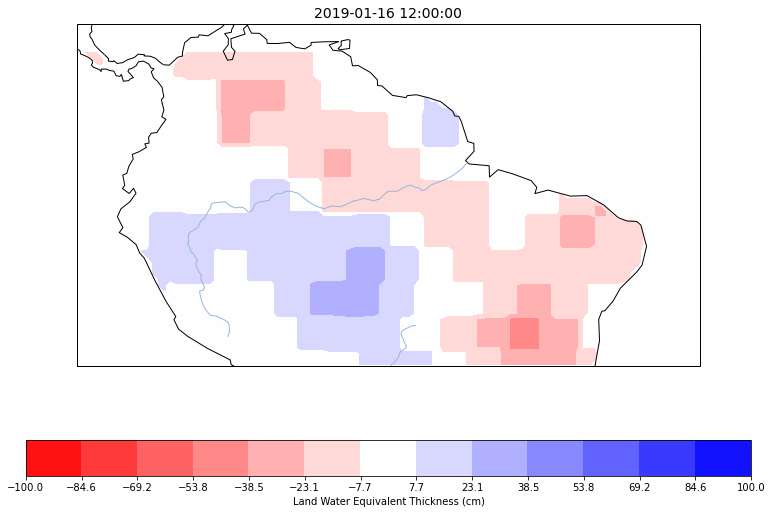

In [10]:
# Initialize a matplotlib plot object and add subplot:
fig = plt.figure(figsize=[13,9]) 
ax = fig.add_subplot(1, 1, 1)

# Configure axes to display projected data using PlateCarree crs:
pmap = plt.axes(projection=ccrs.PlateCarree())

# Get arrays of x and y to label the plot axes:
x,y = np.meshgrid(subset_GRACE.lon, subset_GRACE.lat)                            

# Select Land Water Equivalent Thickness from the GRACE-FO dataset:
lwe = subset_GRACE.lwe_thickness

# Set a few constants for plotting the GRACE-FO time series:
time_start  = 168
cmap_name   = "bwr_r"
cmap_levels = np.linspace(-100., 100., 14)
map_extent  = [-85, -30, -16, 11]

# Plot the first timestep: 
cont = setup_map(ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent)

fig.colorbar(cont, cmap=subset_GRACE, boundaries=cmap_levels, ticks=cmap_levels, orientation='horizontal', label='Land Water Equivalent Thickness (cm)')

User note: You will need to install 'ffmpeg' in the cmd prompt to save the .mpg to disk. Use the following command to install from the conda-forge channel:
```shell
conda install -c conda-forge ffmpeg
```

Create animation of land Water equivalent thickness from GRACE-FO for Amazon Rainforest territories for 2019:

In [11]:
ani = animation.FuncAnimation(fig, animate_ts, frames=range(0,12), fargs=(
    ax, 
    pmap, 
    subset_GRACE, 
    x, 
    y, 
    lwe, 
    time_start, 
    cmap_name, 
    cmap_levels, 
    map_extent,
), interval=500)

HTML(ani.to_html5_video())

In [12]:
ani.save("tutorial7_animation_GRACEFO.mp4", writer=animation.FFMpegWriter())

## On-premise data from Pre-SWOT MEaSUREs

Currently, Pre-SWOT MEaSUREs data do not have the tools required to access them on the cloud, but methods are in the works! 

Data from the [**PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2**](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) dataset can be obtained from the PO.DAAC's on-prem OPeNDAP endpoint. OPeNDAP provides an API on the host server to access data without downloading it. OPeNDAP will also have a cloud component in the future though so this method of access can be on-prem and cloud based moving forward. 

To find the OPeNDAP links needed to open the data using the python package xarray, go to the specific satellite's page on PO.DAAC (ex. Pre-SWOT MEaSUREs's site: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT?sections=about%2Bdata) 

Click on the dataset you want (ex. ) and click the "Data Access" tab. This will give you a link to where you can find the data in OPeNDAP (ex. https://podaac-opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/). 

From there, navigate to the desired NetCDF file and copy it's link (ex. for MEaSUREs, we want the Amazon estuary, so we choose the South America Amazon file: https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc).

Let's look at this example file to see how the data is organized:

In [13]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
ds_MEaSUREs

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes:
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Directory (GCMD)
    cdm_data_type:                 station
    creator_name:                  Coss,Steve
    creator_email:                 Coss.31@osu.edu
    project:                       MEaSUREs OSU
    program:                       NASA Earth Science Data Systems (ESDS)
    publisher_name:                PO.DAAC (Physical Oceanography Distributed...
    publisher_email:               podaac@podaac.jpl.nasa.gov
    publisher_url:                 podaac.jpl.nasa.gov
    publisher_type:                Institution
    publisher_institution:         PO.DAAC
    processing_level:              L2
    doi:                           10.5067/PSGRA-DA2V2
    history:                       This GRRATS product adds data river surfac...
    platform:                      ERS-1(L2),ERS-2(L2),TOPEX/POSEIDON(L2), Ja...
    platform_vocabulary:           NASA/GCMD Platform Keywords. Version 8.6
    instrument:                    RA(L2),RA-2(L2),ALT(TOPEX)(L2),POSEIDON-2(...
    instrument_vocabulary:         NASA/GCMD Platform Keywords. Version 8.6
    references:                    in review :doi.org/10.5194/essd-2019-84
    id:                            GRRATS(Global River Radar Altimeter Time S...
    summary:                       The Global River Radar Altimeter Time Seri...
    time_coverage_resolution:      1 day
    date_created:                  2020-08-12T22:22:39
    time_coverage_start:           1992-04-08T15:20:40
    time_coverage_end:             2018-04-20T03:39:13
    geospatial_lon_min:            -73.35433106652545
    geospatial_lon_max:            -51.0426448887506
    geospatial_lon_units:          degree_east
    geospatial_lat_min:            -4.380427586763687
    geospatial_lat_max:            -0.6550700975069503
    geospatial_lat_units:          degree_north
    geospatial_vertical_max:       92.7681246287056
    geospatial_vertical_min:       -3.563409518163376
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up

The guidebook explains the details of the Pre-SWOT MEaSUREs data:
https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/docs/GRRATS_user_handbookV2.pdf

Our desired variable is height (meters above EGM2008 geoid) for this exercise, which can be subset by distance and time. Distance represents the distance from the river mouth, in this example, the Amazon estuary. Time is between April 8, 1993 and April 20, 2019.

Pre-SWOT MEaSUREs data resides in one NetCDF file for the whole time period, but the same cannot be said for SMAP, Aquarius and MODIS data. They have one file per month for their monthly datasets. SMAP has data from April 2015 - present, Aquarius has data from August 2011 - June 2015, and MODIS has the entire 2011-2019 time period.

First, we create strings of OPeNDAP links lists for each satellite product so we can obtain them and merge them into one file. The links change depending on the date, so the pattern of how the links change needs to be observed and then looped over and appended to the links file list.

**Plotting the river distances and associated heights on the map at time t=9069 (March 16, 2018):**

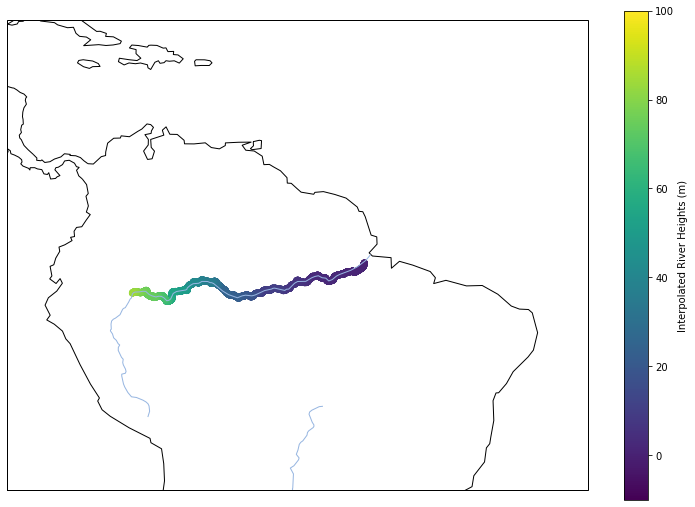

In [14]:
fig = plt.figure(figsize=[13,9]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-85, -30, -20, 20])
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()